In [1]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
import matplotlib.pyplot as plt 
import tensorflow as tf 
import numpy as np 
from skimage import io 
import os
import cv2
import sys
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
base_path="../P2/data/asci"
words_list=[]
words=open(f"{base_path}/words.txt","r").readlines()
for line in words:
    if line[0]=="#":
        continue 
    if line.split(" ")[1]!="err": #we dont need to deal with  errored entries
        words_list.append(line)
len(words_list)
np.random.shuffle(words_list)

In [3]:
split_idx=int(0.9*len(words_list))
train_samples=words_list[:split_idx]
test_samples=words_list[split_idx:]

val_split_idx=int(0.9*len(test_samples))
validation_samples=test_samples[:val_split_idx]
test_samples=test_samples[val_split_idx:]

assert len(words_list)==len(train_samples)+len(validation_samples)+len(test_samples)

print(f"Total train:{len(train_samples)}")
print(f"Total validation:{len(validation_samples)}")
print(f"Total test:{len(test_samples)}")

Total train:86810
Total validation:8681
Total test:965


In [4]:
os.path.getsize('../P2/data/words/a05/a05-013/a05-013-00-02.png')

5965

In [5]:
base_image_path="../P2/data/words"

def get_image_path_and_labels(samples):
    paths=[]
    corrected_samples=[]
    for (i,file_line) in enumerate(samples):
        line_split=file_line.strip()
        line_split=line_split.split(" ")
        
        #each line split will have this format for the corresponding image:
        #part1/part1-part2/part1-part2-part3.png
        image_name=line_split [0]
        partI=image_name.split("-")[0]
        partII=image_name.split("-")[1]
        img_path=(base_image_path+"/"+partI+"/"+partI+"-"+partII+"/"+image_name+".png")
        #img_path=os.path.join(base_image_path,partI,partI+"-"+partII,image_name+".png")
        img_path=os.path.normpath(img_path)
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split('\n')[0])
    return paths,corrected_samples

train_img_paths,train_labels=get_image_path_and_labels(train_samples)
validation_img_paths,validation_labels=get_image_path_and_labels(validation_samples)
test_img_paths,test_labels=get_image_path_and_labels(test_samples)

In [6]:
#find maximum length and size of the vocabulary in the training data
train_labels_cleaned=[]
characters=set()
max_len=0

for label in train_labels:
    label=label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)
    max_len=max(max_len,len(label))
    train_labels_cleaned.append(label)
print("maximum length:",max_len)
print("vocab size:",len(characters))

#check  some label samples.
train_labels_cleaned[:10]

maximum length: 21
vocab size: 78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [7]:
def clean_labels(labels):
    cleaned_labels=[]
    for label in labels:
        label=label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels
        
validation_labels_cleaned=clean_labels(validation_labels)
test_labels_cleaned=clean_labels(test_labels)

In [8]:
AUTOTUNE=tf.data.experimental.AUTOTUNE

#Mapping characters to integers
char_to_num=StringLookup(vocabulary=list(characters),mask_token=None)

#Mapping integers back to original characters
num_to_char=StringLookup(vocabulary=char_to_num.get_vocabulary(),mask_token=None,invert=True)


In [9]:
def distortion_free_resize(image,img_size):
    w,h=img_size
    image=tf.image.resize(image,size=(h,w),preserve_aspect_ratio=True)
    
    #chech the amount of padding needed to be done 
    pad_height=h-tf.shape(image)[0]
    pad_width=w-tf.shape(image)[1]
    
    #only necessary if you want to do same amount of pading on both sides 
    if pad_height%2!=0:
        height =pad_height//2
        pad_height_top=height+1
        pad_height_bottom=height
    else:
        pad_height_top=pad_height_bottom=pad_height//2
    
    if pad_width%2!=0:
        width=pad_width//2
        pad_width_left=width+1
        pad_width_right=width
    else:
        pad_width_left=pad_width_right=pad_width//2
        
    image=tf.pad(image,paddings=[[pad_height_top,pad_height_bottom],[pad_width_left,pad_width_right],[0,0],],)
    image=tf.transpose(image,perm=[1,0,2])
    image=tf.image.flip_left_right(image)
    return image

In [10]:
batch_size=64
padding_token=99
image_width=128
image_height=32

def preprocess_image(image_path,img_size=(image_width,image_height)):
    image=tf.io.read_file(image_path)
    image=tf.image.decode_png(image,1)
    image=distortion_free_resize(image,img_size)
    image=tf.cast(image,tf.float32)/255.0
    return image

def vectorize_label(label):
    label=char_to_num(tf.strings.unicode_split(label,input_encoding="UTF-8"))
    length=tf.shape(label)[0]
    pad_amount=max_len-length
    label=tf.pad(label,paddings=[[0,pad_amount]],constant_values=padding_token)
    return label

def process_images_labels(image_path,label):
    image=preprocess_image(image_path)
    label=vectorize_label(label)
    return {"image":image,"label":label}

def prepare_dataset(image_paths,labels):
    dataset=tf.data.Dataset.from_tensor_slices((image_paths,labels)).map(process_images_labels,num_parallel_calls=AUTOTUNE)
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [11]:
train_ds=prepare_dataset(train_img_paths,train_labels_cleaned)
validation_ds=prepare_dataset(validation_img_paths,validation_labels_cleaned)
test_ds=prepare_dataset(test_img_paths,test_labels_cleaned)

In [12]:
class CTCLayer(keras.layers.Layer):
    def __init__(self,name=None):
        super().__init__(name=name)
        self.loss_fn=keras.backend.ctc_batch_cost
        
    def call(self,y_true,y_pred):
        batch_len=tf.cast(tf.shape(y_true)[0],dtype="int64")
        input_length=tf.cast(tf.shape(y_pred)[1],dtype="int64")
        label_length=tf.cast(tf.shape(y_true)[1],dtype="int64")
        
        input_length=input_length*tf.ones(shape=(batch_len,1),dtype="int64")
        label_length=label_length*tf.ones(shape=(batch_len,1),dtype="int64")
        loss=self.loss_fn(y_true,y_pred,input_length,label_length)
        self.add_loss(loss)
        
        return y_pred

def build_model():
    #inputs to the model 
    input_img=keras.Input(shape=(image_width,image_height,1),name="image")
    labels=keras.layers.Input(name="label",shape=(None,))
    
    #1st block
    x=keras.layers.Conv2D(
        32,
        (3,3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x=keras.layers.MaxPooling2D((2,2),name="pool1")(x)
    
        #2nd block
    x=keras.layers.Conv2D(
        64,(3,3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(input_img)
    x=keras.layers.MaxPooling2D((2,2),name="pool2")(x)
    new_shape=((image_width//4),(image_height) * 64)
    x=keras.layers.Reshape(target_shape=new_shape,name="reshape")(x)
    x=keras.layers.Dense(64,activation="relu",name="dense1")(x)
    x=keras.layers.Dropout(0.2)(x)
    
    #RNNs.
    x=keras.layers.Bidirectional(
      keras.layers.LSTM(128,return_sequences=True,dropout=0.25)
    )(x)
    x=keras.layers.Bidirectional(
      keras.layers.LSTM(64,return_sequences=True,dropout=0.25)
    )(x)
    
    x=keras.layers.Dense(len(char_to_num.get_vocabulary())+2,activation="softmax",name="dense2")(x)
    
    output=CTCLayer(name="ctc_loss")(labels,x)
    
    model=keras.models.Model(
        inputs=[input_img,labels],outputs=output,name="handwritting_recognizer"
    )
    opt=keras.optimizers.Adam()
    
    model.compile(optimizer=opt)
    return model
model=build_model()
model.summary()

Model: "handwritting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv2 (Conv2D)                 (None, 128, 32, 64)  640         ['image[0][0]']                  
                                                                                                  
 pool2 (MaxPooling2D)           (None, 64, 16, 64)   0           ['Conv2[0][0]']                  
                                                                                                  
 reshape (Reshape)              (None, 32, 2048)     0           ['pool2[0][

In [13]:
validation_images=[]
validation_labels=[]
for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [14]:
def calculate_edit_distance(labels,predictions):
    #get a single batch and convert its labels to sparse tensor 
    sparse_labels=tf.cast(tf.sparse.from_dense(labels),dtype=tf.int64)
    
    #make prediction and convert them to sparse tensors 
    input_len=np.ones(predictions.shape[0])*predictions.shape[1]
    predictions_decoded=keras.backend.ctc_decode(
    predictions,input_length=input_len,greedy=True)[0][0][:max_len]
    sparse_predictions=tf.cast(tf.sparse.from_dense(predictions_decoded),dtype=tf.int64)
    #compute individual edit distances and average them out 
    edit_distances=tf.edit_distance(
    sparse_predictions,sparse_labels,normalize=False)
    return tf.reduce_mean(edit_distances)

class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self,pred_model):
        super().__init__()
        self.prediction_model=pred_model
        
    def on_epoch_end(self,epoch,logs=None):
        edit_distances=[]
        for i in range (len(validation_images)):
            labels=validation_labels[i]
            predictions=self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels,predictions).numpy())
        print(
        f"Mean edit distance for epoch {epoch+1} :{np.mean(edit_distances):.4f}" 
        )
        

In [15]:
epochs=10
model=build_model()
predictions_model=keras.models.Model(
    model.get_layer(name="image").input,model.get_layer(name="dense2").output)
edit_distance_callback=EditDistanceCallback(predictions_model)

#train the model 
history=model.fit(
train_ds,validation_data=validation_ds,epochs=epochs,callbacks=[edit_distance_callback])

Epoch 1/10
1357/1357 [==============================] - 420s 306ms/step - loss: 13.7696 - val_loss: 12.8158
Epoch 2/10
1357/1357 [==============================] - 323s 238ms/step - loss: 11.2400 - val_loss: 10.5915
Epoch 3/10
1357/1357 [==============================] - 335s 247ms/step - loss: 9.7612 - val_loss: 9.0650
Epoch 4/10
1357/1357 [==============================] - 350s 258ms/step - loss: 8.5987 - val_loss: 7.6000
Epoch 5/10
1357/1357 [==============================] - 300s 221ms/step - loss: 7.5288 - val_loss: 6.4443
Epoch 6/10
1357/1357 [==============================] - 335s 247ms/step - loss: 6.6229 - val_loss: 5.5293
Epoch 7/10
1357/1357 [==============================] - 317s 234ms/step - loss: 5.9544 - val_loss: 4.8462
Epoch 8/10
1357/1357 [==============================] - 298s 219ms/step - loss: 5.4718 - val_loss: 4.4506
Epoch 9/10
1357/1357 [==============================] - 296s 218ms/step - loss: 5.1105 - val_loss: 4.1026
Epoch 10/10
1357/1357 [===================

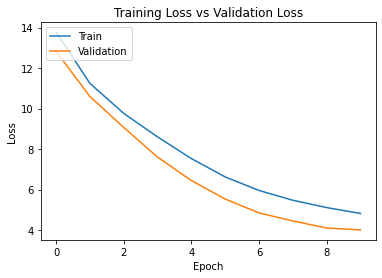

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

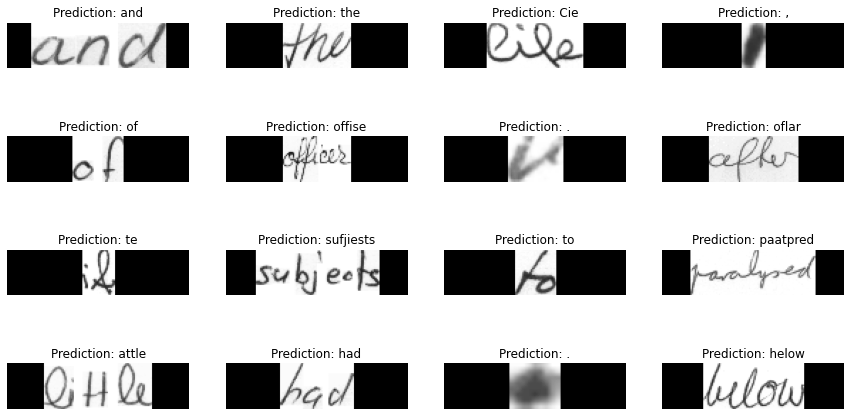

In [18]:
def decode_batch_predictions(pred):
    input_len=np.ones(pred.shape[0])*pred.shape[1]
    
    results=keras.backend.ctc_decode(pred,input_length=input_len,greedy=True)[0][0][:,:max_len]
     
    output_text=[]
    for res in results:
        res=tf.gather(res,tf.where(tf.math.not_equal(res,-1)))
        res=tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text
                                                                                
for batch in test_ds.take(1):
    batch_images=batch["image"]

    _,ax=plt.subplots(4,4,figsize=(15,8))
    preds=predictions_model.predict(batch_images)
    pred_texts=decode_batch_predictions(preds)
    for i in range(16):
        img=batch_images[i]
        img=tf.image.flip_left_right(img)
        img=tf.transpose(img,perm=[1,0,2])
        img=(img*255.0).numpy().clip(0,255).astype(np.uint8)
        img=img[:,:,0]
        title= f"Prediction: {pred_texts[i]}"
        ax[i//4,i%4].imshow(img,cmap="gray")
        ax[i//4,i%4].set_title(title)
        ax[i//4,i%4].axis("off")

In [19]:
batch_images

<tf.Tensor: shape=(64, 128, 32, 1), dtype=float32, numpy=
array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
    

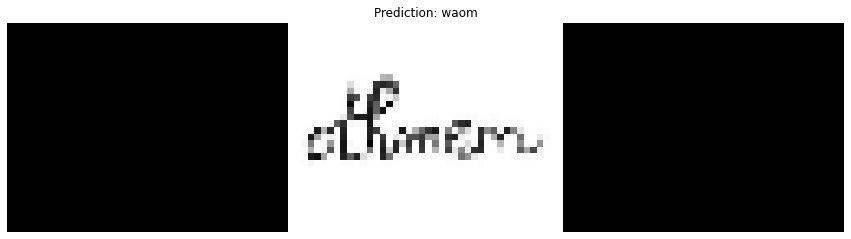

In [26]:
mg="../P2/othmen.png"
tb=prepare_dataset([mg],["okok"])
tb=tb.take(1)
for batch in tb:
    batch_images=batch["image"]
    _,ax=plt.subplots(figsize=(15,8))
    preds=predictions_model.predict(tb)
    pred_texts=decode_batch_predictions(preds) 
    img=batch_images[0]
    img=tf.image.flip_left_right(img)
    img=tf.transpose(img,perm=[1,0,2])
    img=(img*255.0).numpy().clip(0,255).astype(np.uint8)
    img=img[:,:,0]
    title= f"Prediction: {pred_texts[0]}"
    ax.imshow(img,cmap="gray")
    ax.set_title(title)
    ax.axis("off")

In [21]:
from keras.models import load_model
model.save("model.h5")

In [22]:
#from keras.models import load_model

In [23]:
#model = load_model("model.h5")
#loss, accuracy = loaded_model.evaluate(test_data, test_targets)